#Libraries

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
!pip install -q tf-keras-vis

#Feature Engineering

In [ ]:
!unzip /content/archive.zip -d /content/tess_data


Archive:  /content/archive.zip
replace /content/tess_data/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
print("1st: ", os.listdir("/content/tess_data/TESS Toronto emotional speech set data"))

1st:  ['YAF_happy', 'YAF_disgust', 'OAF_neutral', 'YAF_pleasant_surprised', 'OAF_disgust', 'OAF_Fear', 'YAF_neutral', 'YAF_fear', 'YAF_sad', 'OAF_Pleasant_surprise', 'OAF_happy', 'OAF_angry', 'OAF_Sad', 'YAF_angry']


In [ ]:
data_path = "/content/tess_data/TESS Toronto emotional speech set data"

In [ ]:
def load_mfcc_features(folder_path, max_length=174, num_mfcc=40):
    features = []
    labels = []
    for emotion_folder in os.listdir(folder_path):
        emotion_label = emotion_folder.split('_')[-1].lower()
        full_emotion_path = os.path.join(folder_path, emotion_folder)
        for filename in os.listdir(full_emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(full_emotion_path, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=16000)
                mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=num_mfcc).T

                if len(mfcc) < max_length:
                    pad_width = max_length - len(mfcc)
                    mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
                else:
                    mfcc = mfcc[:max_length]

                features.append(mfcc)
                labels.append(emotion_label)

    return np.array(features), np.array(labels)

features, emotions = load_mfcc_features(data_path)
print("Shape of features:", features.shape)
print("Unique emotion labels:", np.unique(emotions))

Shape of features: (2800, 174, 40)
Unique emotion labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise' 'surprised']


In [ ]:
emotions = np.array(['surprise' if label == 'surprised' else label for label in emotions])
np.unique(emotions)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

#Model Training


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(emotions)
onehot_labels = to_categorical(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(features, onehot_labels, test_size=0.2, random_state=42)

In [ ]:
X_train
X_test
y_train
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
model = Sequential([
    Reshape((features.shape[1], features.shape[2], 1), input_shape=(features.shape[1], features.shape[2])),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(onehot_labels.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.9918 - loss: 0.0223 - val_accuracy: 0.9964 - val_loss: 0.0088
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - accuracy: 0.9911 - loss: 0.0334 - val_accuracy: 0.9982 - val_loss: 0.0093
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - accuracy: 0.9930 - loss: 0.0204 - val_accuracy: 0.9982 - val_loss: 0.0057
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - accuracy: 0.9945 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 384ms/step - accuracy: 0.9930 - loss: 0.0161 - val_accuracy: 0.9982 - val_loss: 0.0068
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 301ms/step - accuracy: 0.9966 - loss: 0.0094 - val_accuracy: 0.9929 - val_loss: 0.0391
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.9902 - loss: 0.0352 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.9968 - loss: 0.0178 - val_accu

In [ ]:
replace2linear = ReplaceToLinear()
idx = 0
sample = X_test[idx]
input_tensor = np.expand_dims(sample, axis=0)
true_label = np.argmax(y_test[idx])
score = CategoricalScore([true_label])

In [ ]:
sample_index = 0

sample = X_test[sample_index]
input_tensor = np.expand_dims(sample, axis=0)

true_class = np.argmax(y_test[sample_index])

from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([true_class])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import clone_model

model.layers[-1].activation = tf.keras.activations.linear
modified_model = clone_model(model)
modified_model.set_weights(model.get_weights())

from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(modified_model)
cam = gradcam(score, input_tensor, penultimate_layer=-1)
heatmap = np.squeeze(cam[0])

#Evaluation

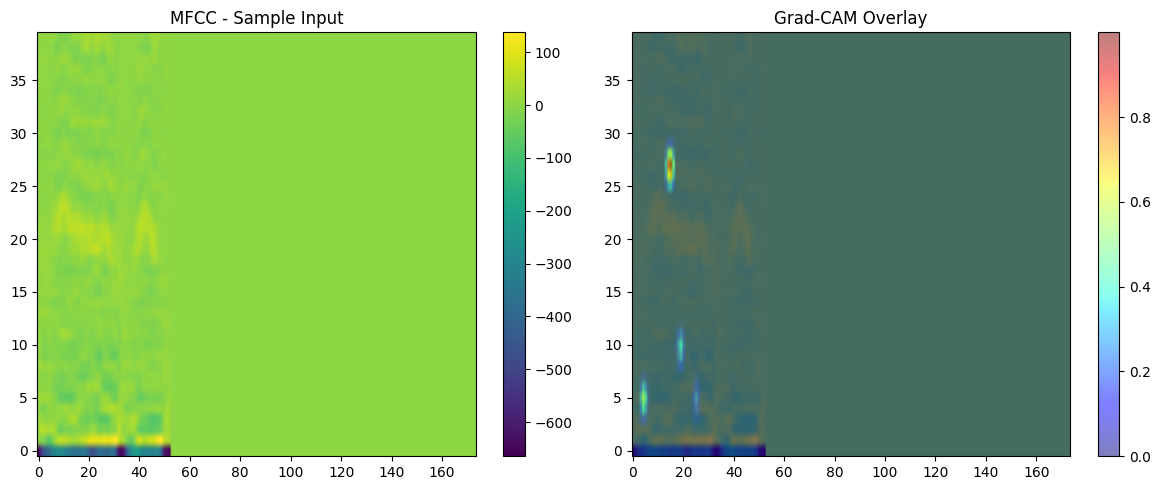

In [ ]:
plt.figure(figsize=(12, 5))
# Left: raw MFCC
plt.subplot(1, 2, 1)
plt.imshow(sample.T, aspect='auto', origin='lower')
plt.title("MFCC - Sample Input")
plt.colorbar()
# Right: Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(sample.T, aspect='auto', origin='lower')
plt.imshow(heatmap.T, cmap='jet', alpha=0.5, aspect='auto', origin='lower')
plt.title("Grad-CAM Overlay")
plt.colorbar()

plt.tight_layout()
plt.show()


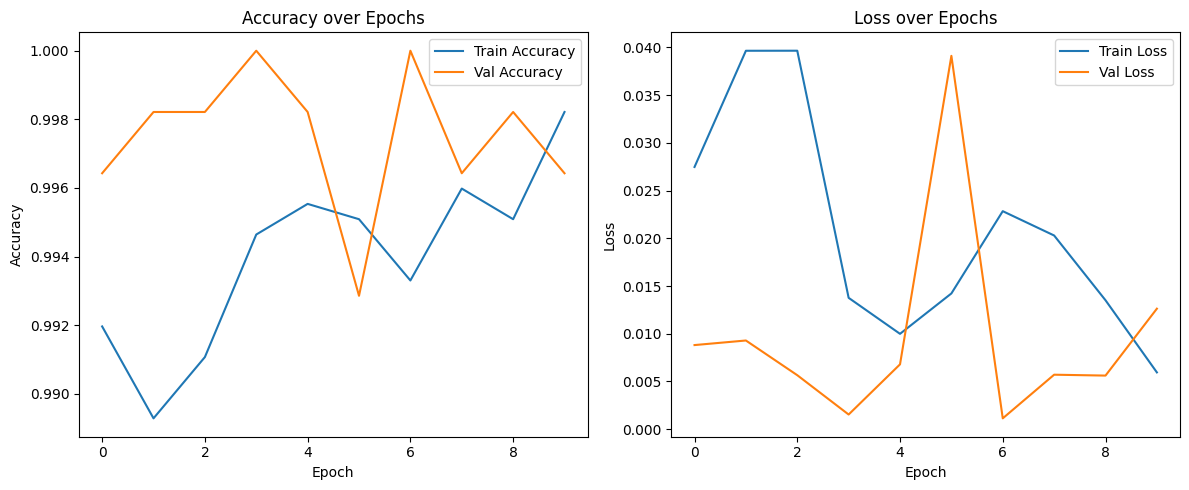

In [ ]:
#Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        76
     disgust       1.00      1.00      1.00        69
        fear       1.00      1.00      1.00        84
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00       101
         sad       1.00      1.00      1.00        79
    surprise       1.00      1.00      1.00        74

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560

